In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ftplib import FTP
import datetime
import re
import zipfile
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5) # set default size of plots

sns.set_style("white")
sns.set_context("talk")
sns.set_palette('Set2', 10)

# Exploring Israel's MOT GTFS files...
Over at [hasadna/open-bus](https://github.com/hasadna/open-bus) we want to build an archive of country-wide bus arrival times. Our way to get there is through a [SIRI interface](https://www.gov.il/he/Departments/General/real_time_information_siri) provided by the Ministry of Transportation. We need to continually make SOAP requests, in such a way so that their aggregated bus location responses will allow us to calculate arrival times for all bus rides across the country. 

In order to do so, I want to first analyze MOT's [static GTFS data](https://www.gov.il/he/Departments/General/gtfs_general_transit_feed_specifications) to figure out what kind of numbers we're talking about, so we can start talking about design and scale for building an efficient and robust archiving module for SIRI realtime info. 

The agenda for this notebook is roughly so: (you can skip to item 3 if you're just interested in the stats):
1. [Get up-to-date GTFS files from the MOT FTP server](#Get-the-data)
2. [Extract the needed info from them into tidy pandas DataFrames](#Tidy-it-up)
3. [Some basic exploratory analysis examples](#Basic-exploratory-analysis)
4. [One the next episodes](#On-the-next-episodes) Yep, not all is covered in this notebook

*side note - Hasadna's OpenBus project has the data in a DB. 
I'm not using it here, since want this notebook to be standalone for further exploration*

# Get the data
Start by making an FTP connection and retrieve the gtfs zip file's modification date. We're restricted from using most commands, but we can LIST...

In [3]:
MOT_FTP = 'gtfs.mot.gov.il'
FILE_NAME = 'israel-public-transportation.zip'
UPTODATE = 150 #days
local_zip_path = 'data/sample/gtfs.zip' 

conn = FTP(MOT_FTP)
conn.login()
ftp_dir = []
conn.retrlines('LIST', lambda x: ftp_dir.append(x)) 
ftp_dir

['11-18-13  03:20PM       <DIR>          aspnet_client',
 '04-03-18  12:21AM                24200 ClusterToLine.zip',
 '04-03-18  12:21AM            224714230 israel-public-transportation.zip',
 '04-03-18  12:21AM               100433 Tariff.zip',
 '04-03-18  12:21AM                30795 TrainOfficeLineId.zip',
 '04-03-18  12:21AM              8636847 TripIdToDate.zip',
 '12-20-17  05:37PM                53105 zones.zip']

Now that we have a list of file records, lets extract the dates and see if our file is up-to-date

In [4]:
RE_FTP_LINE = re.compile(
    r'(?P<date>\d+-\d+-\d+\s+\d+:\d+[APM]{2})\s+(?P<size><DIR>|[0-9]+)\s+(?P<file_name>.*)')
f = [re.findall(RE_FTP_LINE, line) for line in ftp_dir]
f_dates = {t[0][2]: datetime.datetime.strptime(t[0][0], "%m-%d-%y  %H:%M%p") for t in f}

ftp_date = f_dates[FILE_NAME]

have_zip = os.path.exists(local_zip_path)
if have_zip:
    our_date = datetime.datetime.fromtimestamp(os.path.getmtime(local_zip_path))

    our_uptodateness = (ftp_date - our_date).days
    print(f'Our zip is {our_uptodateness} days old')
    if our_uptodateness > UPTODATE:
        print('Oh snap we need to download a new zip...')
    else:
        print('Oh goody! we\'re up-to-date!')


Our zip is 37 days old
Oh goody! we're up-to-date!


And now we shall actually download the zip... if we really want to...

In [5]:
if (have_zip and our_uptodateness > UPTODATE) or not have_zip:
    temp_local_path = 'data/sample/gtfs_temp.zip'
    fh = open(temp_local_path, 'wb')
    conn.retrbinary('RETR %s' % (FILE_NAME), fh.write)
    fh.close()
    #TODO THIS DOESN'T WORK IF YOU DIDN"T HAVE FILE
    os.remove(local_zip_path)
    os.rename(temp_local_path, local_zip_path)

conn.quit()
    

'221 Goodbye.'

In [6]:
h5_file_path = 'data/gtfs_store.h5'
if our_uptodateness > UPTODATE:
    os.remove(h5_file_path)
store = pd.HDFStore(h5_file_path)
if our_uptodateness > UPTODATE:
    with zipfile.ZipFile(local_zip_path) as zf:
        for fn in zf.namelist():
            short = fn.split('.')[0]
            if short not in store:
                store[short] = pd.read_csv(zf.open(fn))

store.stops.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,location_type,parent_station,zone_id
0,1,38831,בי''ס בר לב/בן יהודה,רחוב:בן יהודה 76 עיר: כפר סבא רציף: קומה:,32.183939,34.917812,0,NaN,221.0
1,2,38832,הרצל/צומת בילו,רחוב:הרצל עיר: קרית עקרון רציף: קומה:,31.870034,34.819541,0,NaN,223.0
2,3,38833,הנחשול/הדייגים,רחוב:הנחשול 30 עיר: ראשון לציון רציף: קומה:,31.984558,34.782815,0,NaN,210.0
3,4,38834,פריד/ששת הימים,רחוב:משה פריד 9 עיר: רחובות רציף: קומה:,31.888550,34.790904,0,NaN,223.0
4,6,38836,תחנה מרכזית לוד/הורדה,רחוב: עיר: לוד רציף: קומה:,31.956576,34.898125,0,NaN,210.0


Lets also load MOT's tarrif.txt file, which will give us zone names and other local info

In [7]:
TARIFF_FILE_NAME = 'Tariff.zip'
TARIFF_TXT_NAME = 'Tariff.txt'
TARIFF_TO_REFORM_ZONE = 'StationToReformZone.txt'
local_tariff_path = 'data/sample/tariff.zip' 

conn = FTP(MOT_FTP)
conn.login()
fh = open(local_tariff_path, 'wb')
conn.retrbinary('RETR %s' % (TARIFF_FILE_NAME), fh.write)
fh.close()
conn.quit()

'221 Goodbye.'

# Tidy it up
Many of Seaborn's built-in features call for the data to be in a Pandas DataFrame and to take the form of what Hadley Whickam calls [“tidy” data](http://vita.had.co.nz/papers/tidy-data.pdf). In brief, that means your dataframe should be structured such that each column is a variable and each row is an observation.

Moreover, as Tom Augspurger [claims here](https://tomaugspurger.github.io/modern-5-tidy.html), starting an analysis with a tidy dataset should truly help *"facilitate analysis: going as quickly as possible from question to answer."* I'm taking his word on this now, and hope to show this in work here too.

Later, We'll also play a little bit with pivoting between long and wide formats.

We'll start with one tidy dataset for stop_times, I'll use [partridge](https://github.com/remix/partridge/tree/master/partridge) for filtering on dates. 

In [8]:
import partridge as ptg

service_ids_by_date = ptg.read_service_ids_by_date(local_zip_path)
next_thursday = None #TODO: add this instead of hardcoding the date
service_ids = service_ids_by_date[datetime.date(2018, 3, 1)]

feed = ptg.feed(local_zip_path, view={
    'trips.txt': {
        'service_id': service_ids,
    },
})


The partridge feed now references all the GTFS files in the zip, and will only load them to memory only once used

In [9]:
[x for x in dir(feed) if not x.startswith('__')]

['_io_adapter',
 '_verify_folder_contents',
 '_verify_zip_contents',
 'agency',
 'calendar',
 'calendar_dates',
 'config',
 'fare_attributes',
 'fare_rules',
 'feed_info',
 'frequencies',
 'get',
 'is_dir',
 'path',
 'routes',
 'shapes',
 'stop_times',
 'stops',
 'transfers',
 'trips',
 'view',
 'zmap']

Getting a DataFrame is as easy as...

In [10]:
s = feed.stops
s.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,location_type,parent_station,zone_id
0,1,38831,בי''ס בר לב/בן יהודה,רחוב:בן יהודה 76 עיר: כפר סבא רציף: קומה:,32.183939,34.917812,0,NaN,6900
1,2,38832,הרצל/צומת בילו,רחוב:הרצל עיר: קרית עקרון רציף: קומה:,31.870034,34.819541,0,NaN,469
2,3,38833,הנחשול/הדייגים,רחוב:הנחשול 30 עיר: ראשון לציון רציף: קומה:,31.984558,34.782815,0,NaN,8300
3,4,38834,פריד/ששת הימים,רחוב:משה פריד 9 עיר: רחובות רציף: קומה:,31.888550,34.790904,0,NaN,8400
4,6,38836,תחנה מרכזית לוד/הורדה,רחוב: עיר: לוד רציף: קומה:,31.956576,34.898125,0,NaN,7000


Before we build our first stop times tidy DataFrame, we need zone name data. We need to combine `Tariff.txt` with `StationToReformZone.txt` to a mapping as described in MOT's developers [pdf](https://www.gov.il/BlobFolder/generalpage/gtfs_general_transit_feed_specifications/he/%D7%A1%D7%98%20%D7%A7%D7%91%D7%A6%D7%99%D7%9D%20-%20GTFS%20-%20%D7%94%D7%A1%D7%91%D7%A8%20%D7%9C%D7%9E%D7%A4%D7%AA%D7%97%D7%99%D7%9D_0.pdf).

**Note**: I'm disregarding `FromDate` and `ToDate` and just dropping duplicates. So we will give wrong zone names for zone changes within the GTFS 60 day period.

In [43]:
# not a true csv, so we need to jiggle it a bit
cols = ['ShareCode','ShareCodeDesc','ZoneCodes','Daily','Weekly','Monthly','FromDate','ToDate', 'EXTRA']
reform_cols = ['StationId', 'ReformZoneCode','FromDate','ToDate', 'EXTRA']
with zipfile.ZipFile(local_tariff_path) as zf:
    tariff_df = (pd.read_csv(zf.open(TARIFF_TXT_NAME), header=None, skiprows=[0], names = cols)
                .drop(columns = ['EXTRA']))
    reform_df = (pd.read_csv(zf.open(TARIFF_TO_REFORM_ZONE), header=None, skiprows=[0], names = reform_cols)
                 .drop(columns = ['EXTRA']))

    
# remove ShareCodes which contain multiple zones  e.g. גוש דן מורחב
tariff_df = (tariff_df[~ tariff_df.ZoneCodes.str.contains(';')]
             .rename(columns = {'ShareCodeDesc': 'zone_name',
                               'ZoneCodes': 'zone_id'}))
tariff_df.head()

,ShareCode,zone_name,zone_id,Daily,Weekly,Monthly,FromDate,ToDate
0,141,גוש דן,210,13.5,64.0,213.0,28/03/2018 00:00:00,01/01/2200 00:00:00
10,152,שרון,221,13.5,57.5,149.0,28/03/2018 00:00:00,01/01/2200 00:00:00
11,153,ראש העין שוהם,222,13.5,57.5,149.0,28/03/2018 00:00:00,01/01/2200 00:00:00
12,154,רחובות,223,13.5,57.5,149.0,28/03/2018 00:00:00,01/01/2200 00:00:00
13,155,נתניה,231,13.5,57.5,149.0,28/03/2018 00:00:00,01/01/2200 00:00:00


In [49]:
rs = reform_df[['StationId', 'ReformZoneCode']].drop_duplicates().applymap(str).set_index('StationId').iloc[:,0]
rs.head()

StationId
2716    110
2718    110
2720    110
2721    110
2747    110
Name: ReformZoneCode, dtype: object

In [50]:
ts = (tariff_df[['zone_id', 'zone_name']].drop_duplicates().set_index('zone_id').iloc[:,0])
ts.head()

zone_id
210           גוש דן
221             שרון
222    ראש העין שוהם
223           רחובות
231            נתניה
Name: zone_name, dtype: object

In [61]:
zones = rs.map(ts).reset_index().rename(columns={'StationId': 'stop_code', 'ReformZoneCode':'zone_name'})

And we're ready to build our final stop_times DataFrame. Not a lot of work on it, as it is already in a good tidy format, just select the columns we want, do some transformations and merges.

In [76]:
def to_timedelta(df):
    '''
    Turn time columns into timedelta dtype
    '''
    cols = ['arrival_time']
    numeric = df[cols].apply(pd.to_timedelta, unit='s')
    df = df.copy()
    df[cols] = numeric
    return df

f = (feed.stop_times[['trip_id', 'arrival_time', 'stop_id']]
     .assign(date = datetime.date(2017, 12, 21))
     .merge(s[['stop_id', 'stop_name', 'stop_lat', 'stop_lon', 'stop_code']], on='stop_id')
     # Much faster joins and slices with Categorical dtypes
     .merge(zones, how='left')
     .assign(zone_name=lambda x: pd.Categorical(x['zone_name']))
     .pipe(to_timedelta)
    )
f.head()

,trip_id,arrival_time,stop_id,date,stop_name,stop_lat,stop_lon,stop_code,zone_name
0,26398526_240218,06:37:00,37358,2017-12-21,תל אביב מרכז,32.083715,34.798247,17038,גוש דן
1,30901833_240218,06:07:00,37358,2017-12-21,תל אביב מרכז,32.083715,34.798247,17038,גוש דן
2,30901838_240218,12:07:00,37358,2017-12-21,תל אביב מרכז,32.083715,34.798247,17038,גוש דן
3,30901843_240218,13:07:00,37358,2017-12-21,תל אביב מרכז,32.083715,34.798247,17038,גוש דן
4,30901848_240218,14:07:00,37358,2017-12-21,תל אביב מרכז,32.083715,34.798247,17038,גוש דן


# Basic exploratory analysis

### Big numbers

Overall daily stops

In [77]:
f.shape[0]

3050446

That's a big number, from here on we'll try to better understand its distribution

### Overall stops per minute
First time that I play with this kind of timeseries with pandas, so I'll try a few different ways (including the deprecated seaborn tsplot). Not gonna try to explain how these methods compare... I'm keeping the diversity mostly for educational purposes. 

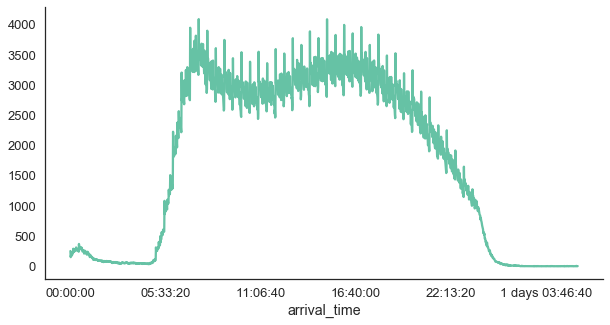

In [91]:
f_1T = f.set_index(['arrival_time']).resample('1T')
f_1T.size().plot()
sns.despine()

In [79]:
f_1T.size().reset_index().head()

,arrival_time,0
0,00:00:00,251
1,00:01:00,150
2,00:02:00,181
3,00:03:00,186
4,00:04:00,171


In [80]:
from statsmodels.nonparametric.smoothers_lowess import lowess
counts = f_1T.size().reset_index().rename(columns={0: 'size'})
smooth_counts = lowess(counts.iloc[:,1], counts.arrival_time, frac=0.01) 
counts['smooth'] = smooth_counts[:, 1]
counts = counts.set_index('arrival_time')
counts['ewm'] = counts['size'].ewm(span=10).mean()
counts.head()

,size,smooth,ewm
arrival_time,,,
00:00:00,251,169.290747,251.000000
00:01:00,150,175.849598,195.450000
00:02:00,181,182.495870,189.641196
00:03:00,186,189.174824,188.441584
00:04:00,171,195.848074,183.434580


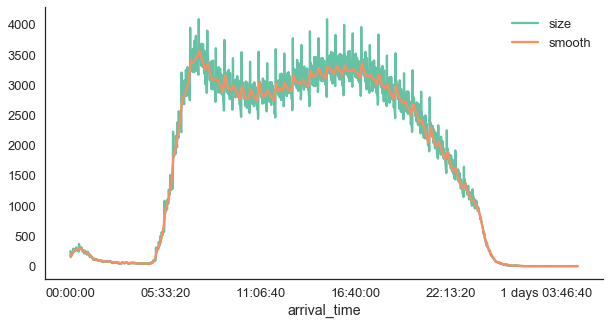

In [92]:
counts[['size', 'smooth']].plot()
sns.despine()

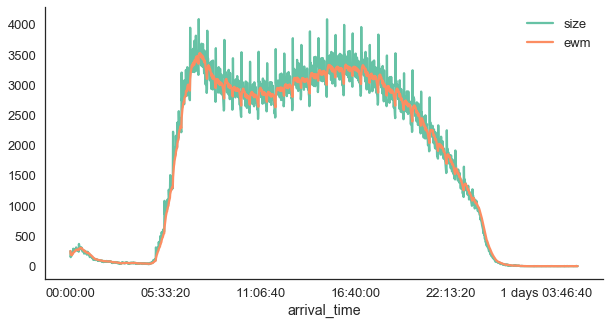

In [93]:
counts[['size', 'ewm']].plot()
sns.despine()

Now build a DF to use with Seaborn tsplot (even though its deprecated)

In [94]:
# one minute counts
c10 = f_1T.size().reset_index().rename(columns={0: 'size'})
# extract minute smalll digit to a new column
c10 = c10.assign(minute=c10.arrival_time.dt.seconds//60%10)
# group the one minute counts into a two level MultiIndex by the 1 minute counts
# and a new resample by 10 minutes. the minute
c10 = c10.set_index('arrival_time').groupby([pd.Grouper(freq='10T'), 'minute']).mean()
# lets look at it in a meaningful way, we can see a peak at the 0  and 5
# (sparkline could be a good viz for this)
c10.reset_index().pivot('arrival_time', 'minute', 'size').iloc[6*7:6*9]

minute,0,1,2,3,4,5,6,7,8,9
arrival_time,,,,,,,,,,
07:00:00,3944,3394,3459,3425,3291,3574,3327,3425,3294,3213
07:10:00,3596,3367,3417,3293,3211,3729,3392,3465,3376,3225
07:20:00,3813,3520,3470,3457,3411,3546,3377,3349,3184,3165
07:30:00,4087,3560,3611,3553,3422,3574,3505,3499,3322,3340
07:40:00,3681,3467,3411,3344,3296,3675,3333,3400,3311,3190
07:50:00,3567,3302,3331,3229,3007,3228,3073,2995,2866,2931
08:00:00,3895,3359,3432,3434,3255,3366,3264,3280,3185,3075
08:10:00,3316,3144,3168,3046,2933,3390,3095,3099,3043,2923
08:20:00,3402,3141,3109,3049,3066,3091,2944,2916,2753,2719


C:\Users\dbare\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


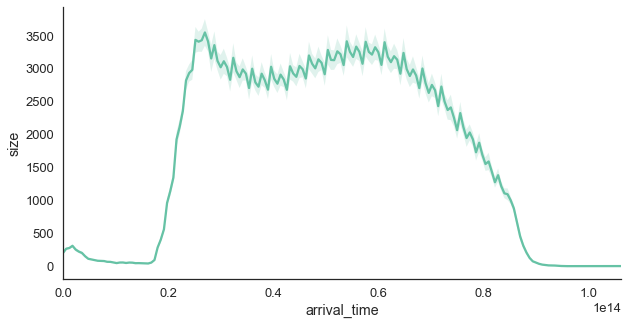

In [95]:
sns.tsplot(data=c10.reset_index(), time='arrival_time', unit='minute', value='size',
           ci='sd')
sns.despine()

The lower opacity color represents the standard deviation.

That's kind of simple to do on our own, so lets do this and some more.

In [96]:
f10 = f_1T.size().resample('10T').apply(['max', 'min', 'mean', 'std'])
f10['ci_l'] = f10['mean'] - f10['std']
f10['ci_h'] = f10['mean'] + f10['std']
f10.head()

,max,min,mean,std,ci_l,ci_h
arrival_time,,,,,,
00:00:00,251,150,202.0,31.411251,170.588749,233.411251
00:10:00,289,236,264.2,18.960778,245.239222,283.160778
00:20:00,310,240,275.8,18.972495,256.827505,294.772495
00:30:00,368,276,308.2,25.698249,282.501751,333.898249
00:40:00,305,209,251.7,25.893157,225.806843,277.593157


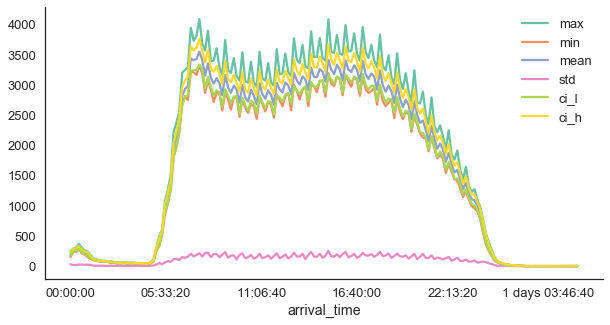

In [97]:
f10.plot()
sns.despine()

Again, one thing to note is the noticeable zigzags of the lines. This is due to round 10 minutes or hours have much more buses scheduled.

### Photo finish
Let's finish with some zone slicing. Starting by getting the top zones overall

Kind of a teaser for future posts, where I'll dive deeper with more slices, groupings and some dynamic dashboarding (woohoo).

Start with getting the top ten zones:

In [98]:
top_zones = f.groupby('zone_name').size().sort_values(ascending=False).head(10)
top_zones.reset_index()

,zone_name,0
0,גוש דן,810197
1,סובב ירושלים,404926
2,סובב חיפה,310534
3,נצרת,140255
4,שרון,110185
5,באר שבע,105101
6,אשדוד,90111
7,נתניה,88064
8,חבל מודיעין,81343
9,ראש העין שוהם,73303


In [99]:
zone10 = (f[f.zone_name.isin(top_zones.index)].set_index('arrival_time')
          .groupby([pd.Grouper(freq='1T'), 'zone_name'])
          .size())
zones10 = zone10.reset_index().rename(columns={0: 'size'})
#reverse names so they will show nicely in plot
zones10 = zones10.assign(zone_name=lambda x: (x['zone_name'].str[::-1]))
zones10 = zones10.pivot('arrival_time', 'zone_name', 'size')

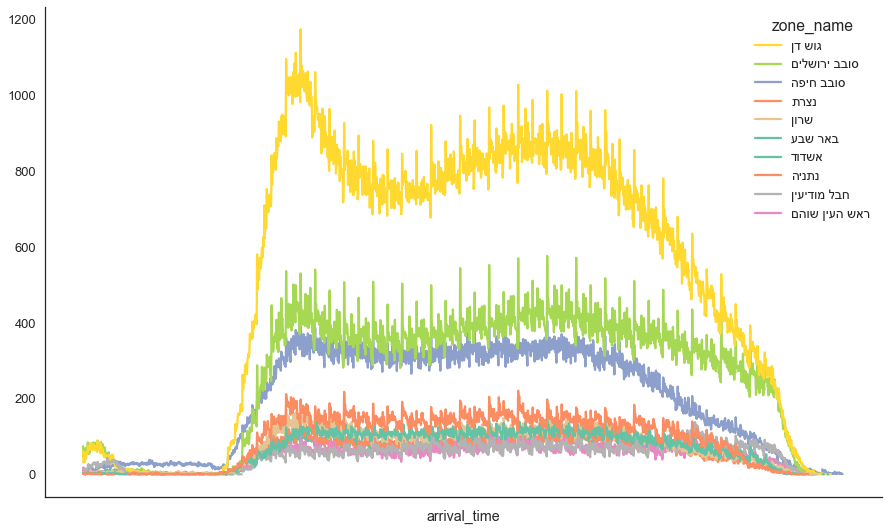

In [100]:
fig, ax = plt.subplots()
zones10.plot(figsize=(15,10), ax=ax)
handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by their rank (and do so in a very weird way :))
top_zones_rank = top_zones.reset_index()
labels, handles = zip(*sorted(zip(labels, handles), 
                              key=lambda t: top_zones_rank[top_zones_rank.zone_name==t[0][::-1]].index.tolist()[0]))
ax.legend(handles, labels, title="zone_name")

sns.despine()

Not very surprising, the Tel Aviv dragon lays well above the rest.

## On the next episodes
OK, enough for now, on the next posts: 

* TODO: Turn it all to day-of-week means
* TODO: Slices on routes and stops
* TODO: calculate bus concurrency (How many buses are on the road right now!)
* TODO: some dynamic bokeh web applet to use this as a tool
* TODO: Geo visualizations 
* TODO: Some graph theory magic ([example](http://kuanbutts.com/2017/12/13/betweenness-centrality-peartree/))